In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Генерация данных

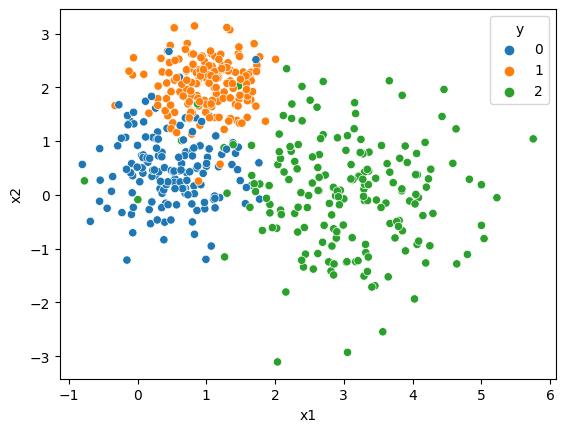

In [2]:
K = 3
true_class_probs = np.array([1 / K] * 3)
class_labels = np.arange(K)
true_mu = np.array([[0.5, 0.5], [1, 2], [3, 0]])
true_sigma_sq = np.array([[0.3, 0.5], [0.2, 0.2], [1, 1]])

N = 500
rng = np.random.default_rng(0)
D_x = []
D_y = []
for _ in range(N):
    y_i = rng.choice(class_labels, 1, p=true_class_probs)[0]
    x_i = rng.multivariate_normal(true_mu[y_i], np.diag(true_sigma_sq[y_i]), 1)[0]
    D_x.append(x_i)
    D_y.append(y_i)
D_x = np.array(D_x)
D_y = np.array(D_y)
# sns.set_theme()
sns.scatterplot(
    data={"x1": D_x[:, 0], "x2": D_x[:, 1], "y": D_y},
    x="x1",
    y="x2",
    hue="y",
    palette="tab10",
);

### 2. Решение задачи
#### Оценка параметров

In [3]:
def loss_function(D_x, D_y, estimated_mu, estimated_sigma_sq):
    sigmas = estimated_sigma_sq[D_y]
    mus = estimated_mu[D_y]
    loss = torch.sum(
        torch.sum(torch.log(sigmas), dim=1)
        + torch.sum((D_x - mus) ** 2 / sigmas, dim=1)
    )
    return loss


# определим параметры модели
torch.manual_seed(0)
estimated_mu = torch.nn.Parameter(torch.rand((3, 2)))
estimated_sigma_sq = torch.nn.Parameter(torch.rand((3, 2)))

# определение оптимизатора
lr = 0.0001
optimizer = torch.optim.SGD(params=[estimated_mu, estimated_sigma_sq], lr=lr)

D_x_tensor = torch.tensor(D_x)
D_y_tensor = torch.tensor(D_y)

epoch_num = 300

for epoch in range(epoch_num):
    optimizer.zero_grad()
    loss = loss_function(D_x_tensor, D_y_tensor, estimated_mu, estimated_sigma_sq)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}: loss {np.round(loss.item(), 4)}")

Epoch 0: loss 5741.6328
Epoch 1: loss 2168.4038
Epoch 2: loss 1934.115
Epoch 3: loss 1768.2502
Epoch 4: loss 1638.7358
Epoch 5: loss 1532.2625
Epoch 6: loss 1441.8702
Epoch 7: loss 1363.4097
Epoch 8: loss 1294.1866
Epoch 9: loss 1232.3411
Epoch 10: loss 1176.5293
Epoch 11: loss 1125.7441
Epoch 12: loss 1079.2084
Epoch 13: loss 1036.3078
Epoch 14: loss 996.5459
Epoch 15: loss 959.5149
Epoch 16: loss 924.875
Epoch 17: loss 892.3396
Epoch 18: loss 861.6654
Epoch 19: loss 832.6447
Epoch 20: loss 805.1001
Epoch 21: loss 778.8814
Epoch 22: loss 753.8622
Epoch 23: loss 729.9397
Epoch 24: loss 707.034
Epoch 25: loss 685.0893
Epoch 26: loss 664.0754
Epoch 27: loss 643.9906
Epoch 28: loss 624.8624
Epoch 29: loss 606.7472
Epoch 30: loss 589.7218
Epoch 31: loss 573.8657
Epoch 32: loss 559.2304
Epoch 33: loss 545.8057
Epoch 34: loss 533.4991
Epoch 35: loss 522.1513
Epoch 36: loss 511.5808
Epoch 37: loss 501.629
Epoch 38: loss 492.1792
Epoch 39: loss 483.1522
Epoch 40: loss 474.494
Epoch 41: loss 46

In [4]:
estimated_mu, true_mu

(Parameter containing:
 tensor([[0.5175, 0.4828],
         [1.0104, 2.0387],
         [3.0098, 0.0223]], requires_grad=True),
 array([[0.5, 0.5],
        [1. , 2. ],
        [3. , 0. ]]))

In [5]:
estimated_sigma_sq, true_sigma_sq

(Parameter containing:
 tensor([[0.2941, 0.4452],
         [0.1873, 0.2150],
         [1.0652, 0.9702]], requires_grad=True),
 array([[0.3, 0.5],
        [0.2, 0.2],
        [1. , 1. ]]))

In [41]:
D_x[1].min()

0.12122455376383123

/tmp/ipykernel_78280/1107477987.py:11: UserWarning: linewidths is ignored by contourf
  plt.contourf(x1, x2, z, alpha=0.5, levels=14, linewidths=0.5, cmap='Blues')


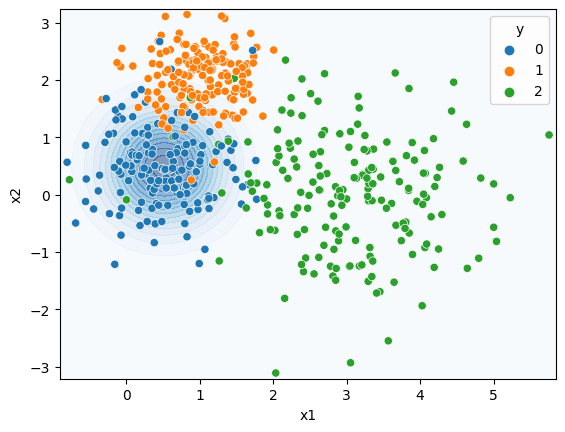

In [46]:
from scipy.stats import multivariate_normal

cm_piyg = plt.cm.PiYG
# sns.set_theme()
sns.scatterplot(
    data={"x1": D_x[:, 0], "x2": D_x[:, 1], "y": D_y},
    x="x1",
    y="x2",
    hue="y",
    palette="tab10",
    zorder=10,
)

rv = multivariate_normal([0.5175, 0.4828], [[0.2941, 0], [0, 0.4452]])
x1, x2 = np.mgrid[
    D_x[:, 0].min() - 0.1 : D_x[:, 0].max() + 0.1 : 0.01,
    D_x[:, 1].min() - 0.1 : D_x[:, 1].max() + 0.1 : 0.01,
]
data = np.dstack((x1, x2))
z = rv.pdf(data)
# z = rv.pdf(data)*0.5 + 0.5
plt.contourf(x1, x2, z, alpha=0.5, levels=14, linewidths=0.5, cmap="Blues")
plt.show()

#### Апостериорное распределение классов

In [59]:
def get_probability(points, estimated_mu, estimated_sigma_sq):
    # rv = multivariate_normal(estimated_mu[c], np.diag(estimated_sigma_sq[c]))
    # likelihood = rv.pdf(points)
    K = estimated_mu.shape[0]
    likelihoods = []
    for i in range(K):
        rv = multivariate_normal(
            estimated_mu.detach().numpy()[i],
            np.diag(estimated_sigma_sq.detach().numpy()[i]),
        )
        likelihoods.append([rv.pdf(points)])
    likelihoods = np.concatenate(likelihoods, axis=0)
    return likelihoods / np.sum(likelihoods, axis=0)


class_to_cmap = {0: "Blues", 1: "Oranges", 2: "Greens"}

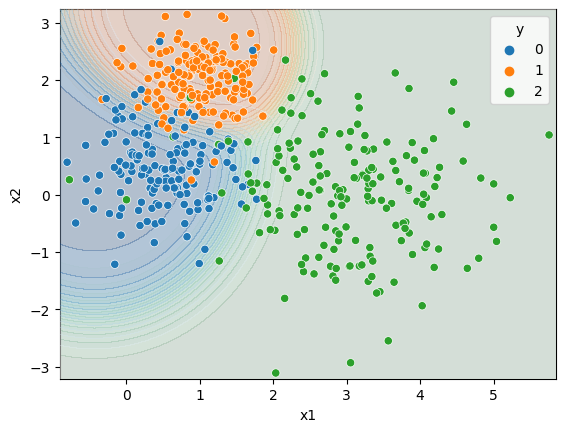

In [62]:
sns.scatterplot(
    data={"x1": D_x[:, 0], "x2": D_x[:, 1], "y": D_y},
    x="x1",
    y="x2",
    hue="y",
    palette="tab10",
    zorder=10,
)
z = get_probability(np.dstack((x1, x2)), estimated_mu, estimated_sigma_sq)
for c in [0, 1, 2]:
    plt.contourf(
        x1, x2, z[c], alpha=0.3, levels=14, cmap=class_to_cmap[c], zorder=4 - c
    )
plt.show()

#### Граница классификации

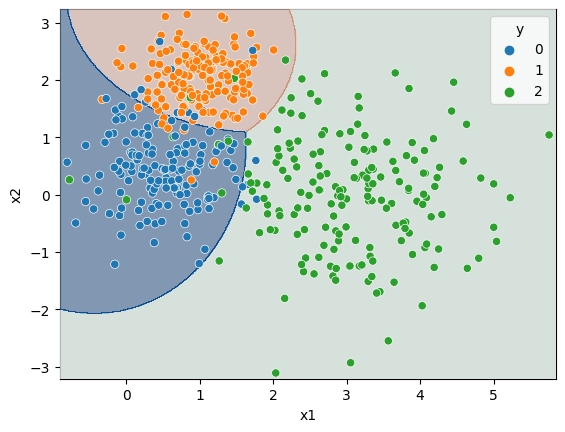

In [78]:
sns.scatterplot(
    data={"x1": D_x[:, 0], "x2": D_x[:, 1], "y": D_y},
    x="x1",
    y="x2",
    hue="y",
    palette="tab10",
    zorder=10,
)
for c in [0, 1, 2]:
    plt.contourf(
        x1,
        x2,
        z[c] == np.max(z, axis=0),
        alpha=0.5,
        levels=14,
        cmap=class_to_cmap[c],
        zorder=4 - c,
    )
plt.show()